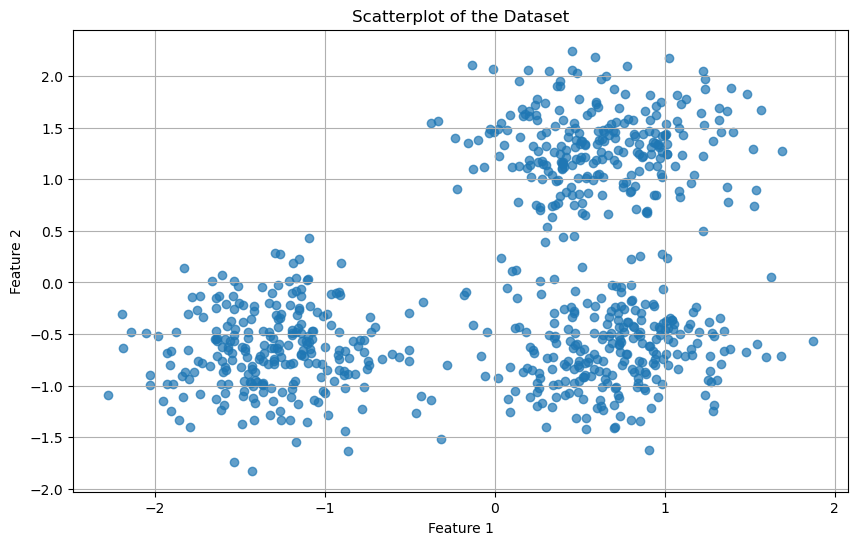

In [1]:
# Question 1

import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'datasets/clustering_synthetic_dataset.csv'  
data = pd.read_csv(file_path)

# Plotting the scatterplot of the dataset
plt.figure(figsize=(10, 6))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], alpha=0.7) 
plt.title('Scatterplot of the Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()


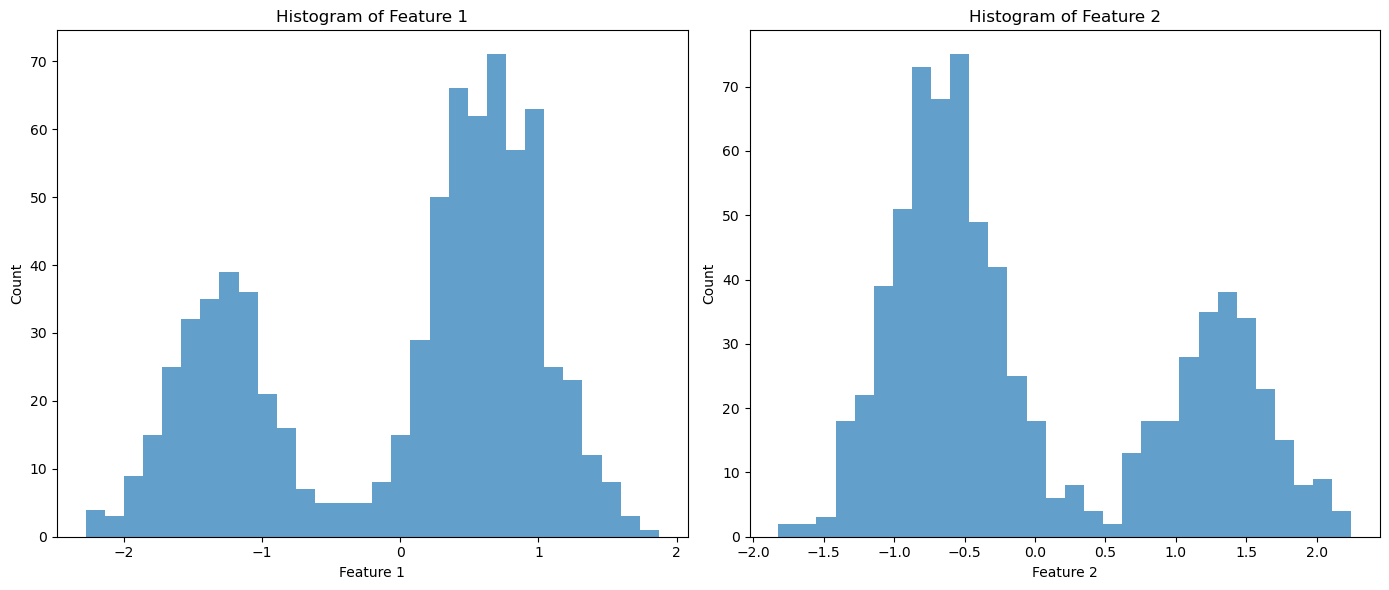

In [2]:
# Question 2

import matplotlib.pyplot as plt

# Visualize the feature distributions using histograms
plt.figure(figsize=(14, 6))

# Feature 1
plt.subplot(1, 2, 1)
plt.hist(data['f1'], bins=30, alpha=0.7)
plt.title('Histogram of Feature 1')
plt.xlabel('Feature 1')
plt.ylabel('Count')

# Feature 2
plt.subplot(1, 2, 2)
plt.hist(data['f2'], bins=30, alpha=0.7)
plt.title('Histogram of Feature 2')
plt.xlabel('Feature 2')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [3]:
# Question 2

# Calculate the mean and standard deviation for each feature
feature_stats = data.describe().loc[['mean', 'std']]

# Calculate the bounds within 2 standard deviations
feature_stats.loc['lower_bound'] = feature_stats.loc['mean'] - 2 * feature_stats.loc['std']
feature_stats.loc['upper_bound'] = feature_stats.loc['mean'] + 2 * feature_stats.loc['std']

feature_stats

,f1,f2
mean,5.222933e-15,-7.853925e-14
std,1.000667e+00,1.000667e+00
lower_bound,-2.001335e+00,-2.001335e+00
upper_bound,2.001335e+00,2.001335e+00


**Question 2**

Based on the calculations:

- **Feature 1** has a mean of approximately 0 and a standard deviation of about 1. Therefore, the 'core' range for Feature 1, within two standard deviations from the mean, is roughly from -2.00 to 2.00.
- **Feature 2** has a similar distribution with a mean close to 0 and a standard deviation of 1. Its 'core' range is also from -2.00 to 2.00.

In [4]:
# Question 3

from sklearn.cluster import KMeans

n_clusters = 3

# Fit KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(data[['f1', 'f2']])

# Find the centroids
centroids = kmeans.cluster_centers_

# Calculate the distance from each point to its cluster centroid
distances = kmeans.transform(data[['f1', 'f2']])  # Get distances to each centroid

# Add distance to the nearest centroid for each data point
data['distance_to_centroid'] = distances.min(axis=1)

# Identify anomalies as points that are far from the centroids
distance_threshold = data['distance_to_centroid'].quantile(0.90)
anomalies = data[data['distance_to_centroid'] > distance_threshold]

# Output the potential anomalies
anomalies.head()

,f1,f2,cluster,distance_to_centroid
5,-1.261570,0.271881,1,0.929832
16,-1.430208,-1.823801,1,1.173709
18,-0.506014,-0.295715,1,0.874760
32,-1.858047,-1.330218,1,0.872707
39,-0.166999,-0.091653,0,1.024397


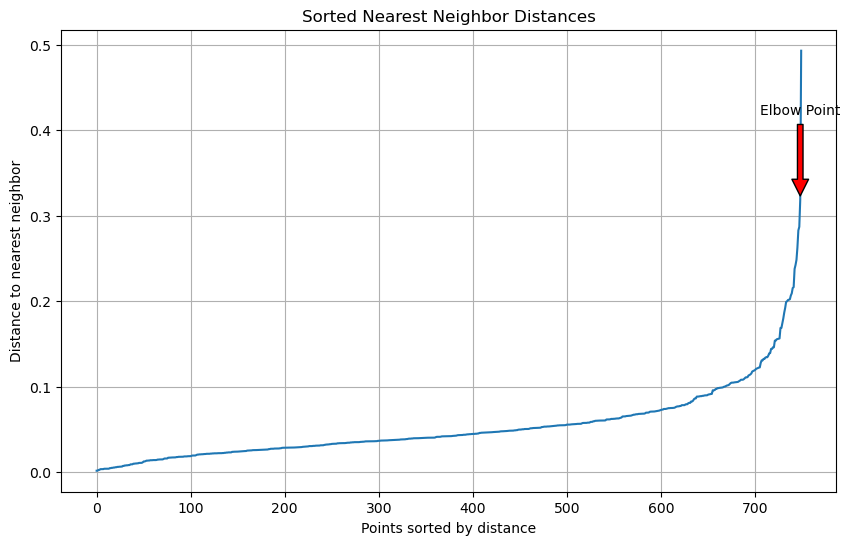

In [5]:
# Question 4

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data[['f1', 'f2']])
distances, indices = nbrs.kneighbors(data[['f1', 'f2']])
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Plotting the distances
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('Sorted Nearest Neighbor Distances')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to nearest neighbor')
plt.grid(True)

# Annotating the 'knee'
knee_index = np.argmax(np.diff(distances))
knee_value = distances[knee_index]
plt.annotate('Elbow Point', xy=(knee_index, knee_value),
             xytext=(knee_index, knee_value + 0.1),
             arrowprops=dict(facecolor='red', shrink=0.05),
             ha='center')

plt.show()

# The 'eps' value for DBSCAN would be approximately the distance at the 'knee'.
eps_value = knee_value


In [6]:
# Question 4

from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
# The parameters eps and min_samples need to be chosen appropriately
# For this demonstration, we'll choose common starting values, but these should be fine-tuned
dbscan = DBSCAN(eps_value, min_samples=5)
data['dbscan_cluster'] = dbscan.fit_predict(data[['f1', 'f2']])

# Any point that has a cluster label of -1 is considered an anomaly by DBSCAN
data['is_anomaly'] = data['dbscan_cluster'] == -1

# Extract anomalies
anomalies_dbscan = data[data['is_anomaly']]

anomalies_dbscan.head()


,f1,f2,cluster,distance_to_centroid,dbscan_cluster,is_anomaly
16,-1.430208,-1.823801,1,1.173709,-1,True
76,-0.134479,2.110397,2,1.096469,-1,True
135,-1.531992,-1.741468,1,1.108410,-1,True
165,-0.463075,-1.265318,1,1.036777,-1,True
273,1.621982,0.050201,0,1.157994,-1,True


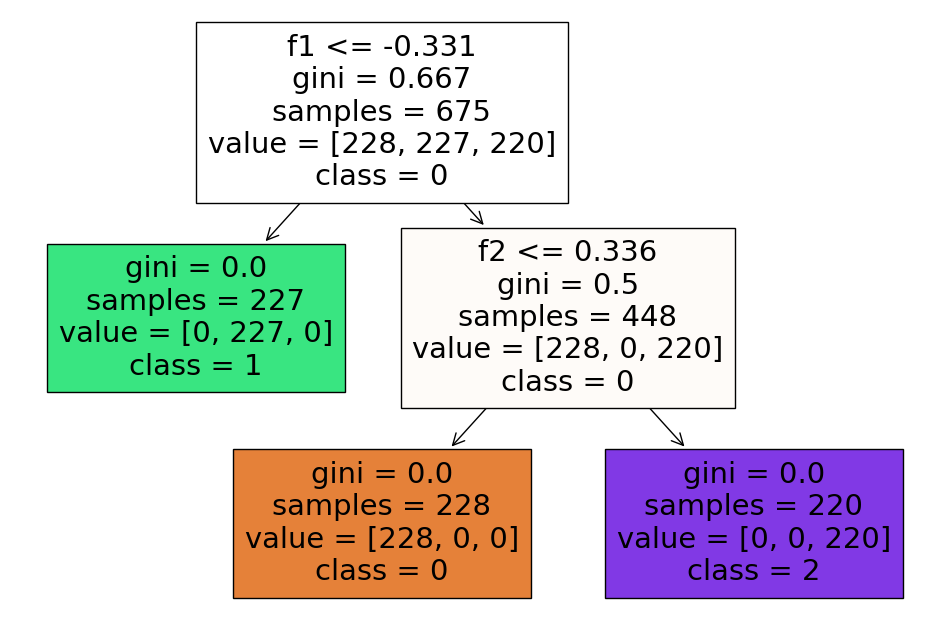

In [7]:
# Question 5 

from sklearn.tree import DecisionTreeClassifier, plot_tree

# Using K-means results
# Remove the anomalous points from the dataset
clean_data = data[~data.index.isin(anomalies.index)]
clean_data.to_csv('cleaned_clustering_synthetic_dataset.csv', index=False)


# The cluster labels from K-means will be used as the target for classification.
X = clean_data[['f1', 'f2']]  # Features
y = clean_data['cluster']      # Target variable (cluster labels)

# Train the decision tree classifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X, y)

# Now let's visualize the decision tree
plt.figure(figsize=(12,8))
plot_tree(dt_clf, filled=True, feature_names=['f1', 'f2'], class_names=np.unique(y).astype(str))
plt.show()


In [8]:
# Question 6

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Define the features and labels from the original dataset
X_original = data[['f1', 'f2']]
y_original = data['cluster']  

# Split the original dataset into training and test sets
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    X_original, y_original, test_size=0.3, random_state=42)

# Train a decision tree classifier on the original dataset
dt_clf_original = DecisionTreeClassifier(random_state=42)
dt_clf_original.fit(X_train_original, y_train_original)

# Evaluate the classifier on the test set
y_pred_original = dt_clf_original.predict(X_test_original)
print(classification_report(y_test_original, y_pred_original))
print(confusion_matrix(y_test_original, y_pred_original))

# Compare with the cleaned data (this part comes from your code for question 5)
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(
    X, y, test_size=0.3, random_state=42)

y_pred_cleaned = dt_clf.predict(X_test_cleaned)
print(classification_report(y_test_cleaned, y_pred_cleaned))
print(confusion_matrix(y_test_cleaned, y_pred_cleaned))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        75

    accuracy                           1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225

[[74  0  0]
 [ 0 76  0]
 [ 0  0 75]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00        68
           2       1.00      1.00      1.00        62

    accuracy                           1.00       203
   macro avg       1.00      1.00      1.00       203
weighted avg       1.00      1.00      1.00       203

[[73  0  0]
 [ 0 68  0]
 [ 0  0 62]]


In [9]:
# Question 6
# Evaluation
report_original = classification_report(y_test_original, y_pred_original, output_dict=True)
report_clean = classification_report(y_test_cleaned, y_pred_cleaned, output_dict=True)
cm_original = confusion_matrix(y_test_original, y_pred_original)
cm_clean = confusion_matrix(y_test_cleaned, y_pred_cleaned)

# Prepare analysis
analysis = {
    "Original Dataset": {
        "Classification Report": report_original,
        "Confusion Matrix": cm_original
    },
    "Cleaned Dataset": {
        "Classification Report": report_clean,
        "Confusion Matrix": cm_clean
    }
}

analysis


{'Original Dataset': {'Classification Report': {'0': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 74},
   '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 76},
   '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 75},
   'accuracy': 1.0,
   'macro avg': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 225},
   'weighted avg': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 225}},
  'Confusion Matrix': array([[74,  0,  0],
         [ 0, 76,  0],
         [ 0,  0, 75]])},
 'Cleaned Dataset': {'Classification Report': {'0': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 73},
   '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 68},
   '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 62},
   'accuracy': 1.0,
   'macro avg': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 203},
   'weighted 

**Analysis: **

**Results:**
- **Original Dataset:**
  - Precision, Recall, and F1-score: 100% for each class.
  - Accuracy: 100%.
  - Confusion Matrix: Perfect classification with no misclassifications.

- **Cleaned Dataset (Post-Anomaly Removal):**
  - Precision, Recall, and F1-score: 100% for each class.
  - Accuracy: 100%.
  - Confusion Matrix: Perfect classification with no misclassifications.

**Interpretation:**
- **Accuracy Analysis:** Both the original and the cleaned dataset models achieved perfect accuracy. This implies that the removal of outliers/anomalies did not result in a measurable improvement in accuracy.
  
- **Impact of Outlier Removal:** The lack of accuracy improvement suggests that the decision tree model was robust enough to handle outliers in the original dataset. 
- **Dataset Characteristics:** Given that the dataset is synthetic, it's possible that the underlying data distribution was such that the outliers did not significantly affect the model's ability to classify the data correctly.